## 0\. Motivação

Supondo que tenha empreendedor no ramo imobiliário e ele quer decidir qual a melhor região para construir, será preciso todo um estudo comparativo para encontrar a resposta. 

Esse notebook tem como objetivo facilitar esse processo. Para isso, será feito uma comparação entre bases de dados distintas para se chegar nas áreas mais rentáveis para construção por m².

## 1\. Coleta de dados

In [1]:
import os
import re
import csv

import requests
from requests.exceptions import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np

Primeiro será feita a coleta de dados pelo scraping, pois a base de dados está em HTML no site em questão. Os valores são referentes ao mês de Março de 2023.

In [2]:
def crawl_website(url: str) -> str:

  try:
    resposta = requests.get(url)
    resposta.raise_for_status()
  except HTTPError as exc:
    print(exc)
  else:
    return resposta.text

URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'

robots = crawl_website(url=URL)

if  re.findall('ranking', robots, re.IGNORECASE) == True or re.findall('project', robots, re.IGNORECASE) == False:
  print(True) 
else:
  print(False) 

False


In [3]:
URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'
conteudo = crawl_website(url=URL)

pagina = BeautifulSoup(conteudo, 'html.parser')
tabela = pagina.find('table', {'class': 'bairro'}).text.split('\n\n\n')

In [4]:
dados = []
for linha in tabela:
    teste = linha.split('\n')
    dados.append(teste)

In [5]:
resultado = [[value.replace('R$', '').replace('%', '').replace('-','').replace('+','').replace('.','').strip() for value in linha if value] for linha in dados]
preco_m2_df = pd.DataFrame(resultado[1:], columns=resultado[0])
preco_m2_df = preco_m2_df[['Bairro','Preço/M²']].rename(columns={'Bairro':'district','Preço/M²':'price_per_m2'})

preco_m2_df['price_per_m2'] = preco_m2_df['price_per_m2'].astype('Int64')

preco_m2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   district      550 non-null    object
 1   price_per_m2  550 non-null    Int64 
dtypes: Int64(1), object(1)
memory usage: 9.3+ KB


Esse outro dataset foi retirado do Kaggle. Tal dataset tem como base os valores dos aluguéis disponiveis pelo Quinto Andar, um site de aluguéis de imóveis bem famoso. A data referência é a de Maio de 2023, apenas 2 meses a mais do que a outra base de dados anteriormente coletada.
 
Link: https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices

In [7]:
# Leitura dos dados de locações em SP
sp_df = pd.read_csv('saopaulo_precos.csv')
sp_df

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
...,...,...,...,...,...,...,...,...
11652,Avenida Adolfo Pinheiro,Santo Amaro,94,2,1,Apartamento,4100,5778
11653,Rua Professor Alexandre Correia,Jardim Vitória Régia,350,4,4,Apartamento,11250,17480
11654,Rua Abílio Borin,Jardim Caravelas,84,1,2,Apartamento,4500,5467
11655,Rua Forte William,Jardim Fonte do Morumbi,76,1,0,Apartamento,9000,10200


In [7]:
data = pd.merge(left=sp_df,right=preco_m2_df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   address       9048 non-null   object
 1   district      9048 non-null   object
 2   area          9048 non-null   int64 
 3   bedrooms      9048 non-null   int64 
 4   garage        9048 non-null   int64 
 5   type          9048 non-null   object
 6   rent          9048 non-null   int64 
 7   total         9048 non-null   int64 
 8   price_per_m2  9048 non-null   Int64 
dtypes: Int64(1), int64(5), object(3)
memory usage: 645.1+ KB


In [8]:
data['valor_estimado_area'] = data['area']*data['price_per_m2']
data

,address,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939,8184,171864
1,Avenida Celso Garcia,Belenzinho,44,2,1,Apartamento,1850,2321,8184,360096
2,Rua Herval,Belenzinho,40,1,0,Apartamento,1800,2069,8184,327360
3,Rua Herval,Belenzinho,30,1,0,Apartamento,1800,2069,8184,245520
4,Rua Serra da Mantiqueira,Belenzinho,100,3,0,Casa,3850,4113,8184,818400
...,...,...,...,...,...,...,...,...,...,...
9043,Rua João Teizen Sobrinho,Jardim Santa Helena,310,4,4,Casa,10000,11390,4852,1504120
9044,Rua Edmundo Amaral Valente,Parque Munhoz,56,2,2,Apartamento,1500,2188,5125,287000
9045,"Parque do Morumbi, São Paulo - Sp, 05706-290, ...",Parque do Morumbi,140,3,2,Apartamento,3000,4399,10357,1449980
9046,Avenida Dona Helena Pereira de Moraes,Parque do Morumbi,220,2,0,Apartamento,11250,16620,10357,2278540


Aqui eu retirei a lista dos bairros existentes em São Paulo, para delimitar apenas os endereços na cidade.

In [8]:
bairros = []

URL2 = 'https://www.estadosecapitaisdobrasil.com/lista-dos-bairros-de-sao-paulo/'
conteudo2 = crawl_website(url=URL2)

pagina2 = BeautifulSoup(conteudo2, 'html.parser')
tabela2 = pagina2.find('div', {'class': 'content col-8'}).find_all('ul')

for linha in tabela2:
    if linha is None:
        continue
    
    linha = str(linha)
    
    linha = linha.replace('\n', '').replace('</ul>', '').replace('</li>','').replace('\u200e','')
    
    nomes = linha.split('<li>')[1:]
    
    nomes = [nome.strip().rstrip('') for nome in nomes]
    
    bairros.extend(nomes)

print(bairros)

['Água Rasa', 'Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim', 'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia', 'Butantã', 'Cachoeirinha', 'Cambuci', 'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba', 'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar', 'Cidade Dutra', 'Cidade Líder', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação', 'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú', 'Guaianases', 'Iguatemi', 'Ipiranga', 'Itaim Bibi', 'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaçanã', 'Jaguara', 'Jaguaré', 'Jaraguá', 'Jardim Ângela', 'Jardim Helena', 'Jardim Paulista', 'Jardim São Luís', 'Lapa', 'Liberdade', 'Limão', 'Mandaqui', 'Marsilac', 'Moema', 'Mooca', 'Morumbi', 'Parelheiros', 'Pari', 'Parque do Carmo', 'Penha', 'Perdizes', 'Pinheiros', 'Ponte Rasa', 'Raposo Tavares', 'República', 'Rio Pequeno', 'Sacomã', 'Santa Cecília', 'Santana', 'Santo Amaro', 'São Domingos', 'São Lucas', 'São Mateus', 'São Miguel Paulista', 'São Rafae

## 3\. Exploração dos dados

In [28]:
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

In [13]:
# Criar o DataFrame
df = data

# Geocodificação dos endereços
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)
geocode = geolocator.geocode

df['location'] = df['address'] + ', ' + df['district'] + ', São Paulo, SP' # Concatena o endereço com a cidade e estado

df['coordinates'] = df['location'].apply(geocode).apply(lambda x: (x.latitude, x.longitude) if x else None)


,address,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,location,coordinates
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939,8184,171864,"Rua Herval, Belenzinho, São Paulo, SP",None
1,Avenida Celso Garcia,Belenzinho,44,2,1,Apartamento,1850,2321,8184,360096,"Avenida Celso Garcia, Belenzinho, São Paulo, SP",None
2,Rua Herval,Belenzinho,40,1,0,Apartamento,1800,2069,8184,327360,"Rua Herval, Belenzinho, São Paulo, SP",None
3,Rua Herval,Belenzinho,30,1,0,Apartamento,1800,2069,8184,245520,"Rua Herval, Belenzinho, São Paulo, SP",None
4,Rua Serra da Mantiqueira,Belenzinho,100,3,0,Casa,3850,4113,8184,818400,"Rua Serra da Mantiqueira, Belenzinho, São Paul...",None


In [18]:
df.to_csv('teste.csv')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5454 entries, 31 to 9045
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   address              5454 non-null   object
 1   district             5454 non-null   object
 2   area                 5454 non-null   int64 
 3   bedrooms             5454 non-null   int64 
 4   garage               5454 non-null   int64 
 5   type                 5454 non-null   object
 6   rent                 5454 non-null   int64 
 7   total                5454 non-null   int64 
 8   price_per_m2         5454 non-null   Int64 
 9   valor_estimado_area  5454 non-null   Int64 
 10  location             5454 non-null   object
 11  coordinates          5454 non-null   object
dtypes: Int64(2), int64(5), object(5)
memory usage: 564.6+ KB


In [83]:
bairros = []

URL2 = 'https://www.estadosecapitaisdobrasil.com/lista-dos-bairros-de-sao-paulo/'
conteudo2 = crawl_website(url=URL2)

pagina2 = BeautifulSoup(conteudo2, 'html.parser')
tabela2 = pagina2.find('div', {'class': 'content col-8'}).find_all('ul')

for linha in tabela2:
    if linha is None:
        continue
    
    linha = str(linha)
    
    linha = linha.replace('\n', '').replace('</ul>', '').replace('</li>','').replace('\u200e','')
    
    nomes = linha.split('<li>')[1:]
    
    nomes = [nome.strip().rstrip('') for nome in nomes]
    
    bairros.extend(nomes)

print(bairros)

['Água Rasa', 'Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim', 'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia', 'Butantã', 'Cachoeirinha', 'Cambuci', 'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba', 'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar', 'Cidade Dutra', 'Cidade Líder', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação', 'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú', 'Guaianases', 'Iguatemi', 'Ipiranga', 'Itaim Bibi', 'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaçanã', 'Jaguara', 'Jaguaré', 'Jaraguá', 'Jardim Ângela', 'Jardim Helena', 'Jardim Paulista', 'Jardim São Luís', 'Lapa', 'Liberdade', 'Limão', 'Mandaqui', 'Marsilac', 'Moema', 'Mooca', 'Morumbi', 'Parelheiros', 'Pari', 'Parque do Carmo', 'Penha', 'Perdizes', 'Pinheiros', 'Ponte Rasa', 'Raposo Tavares', 'República', 'Rio Pequeno', 'Sacomã', 'Santa Cecília', 'Santana', 'Santo Amaro', 'São Domingos', 'São Lucas', 'São Mateus', 'São Miguel Paulista', 'São Rafae

In [85]:
df_filtro = df[df['district'].isin(bairros)]
df_filtro.info()



<class 'pandas.core.frame.DataFrame'>
Index: 3160 entries, 37 to 9018
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   address              3160 non-null   object
 1   district             3160 non-null   object
 2   area                 3160 non-null   int64 
 3   bedrooms             3160 non-null   int64 
 4   garage               3160 non-null   int64 
 5   type                 3160 non-null   object
 6   rent                 3160 non-null   int64 
 7   total                3160 non-null   int64 
 8   price_per_m2         3160 non-null   Int64 
 9   valor_estimado_area  3160 non-null   Int64 
 10  location             3160 non-null   object
 11  coordinates          3160 non-null   object
dtypes: Int64(2), int64(5), object(5)
memory usage: 327.1+ KB


In [80]:
mapa = gpd.read_file("./DISTRITO_MUNICIPAL_SP_SMDU/DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")
mapa.head()

,Codigo,Nome,geometry
0,51,MANDAQUI,"POLYGON ((-46.65470 -23.43063, -46.65468 -23.4..."
1,52,MARSILAC,"POLYGON ((-46.60987 -23.90550, -46.60990 -23.9..."
2,32,MOEMA,"POLYGON ((-46.65361 -23.57219, -46.65359 -23.5..."
3,57,PARQUE DO CARMO,"POLYGON ((-46.44461 -23.59272, -46.44470 -23.5..."
4,60,PERDIZES,"POLYGON ((-46.66355 -23.53692, -46.66362 -23.5..."


<Axes: >

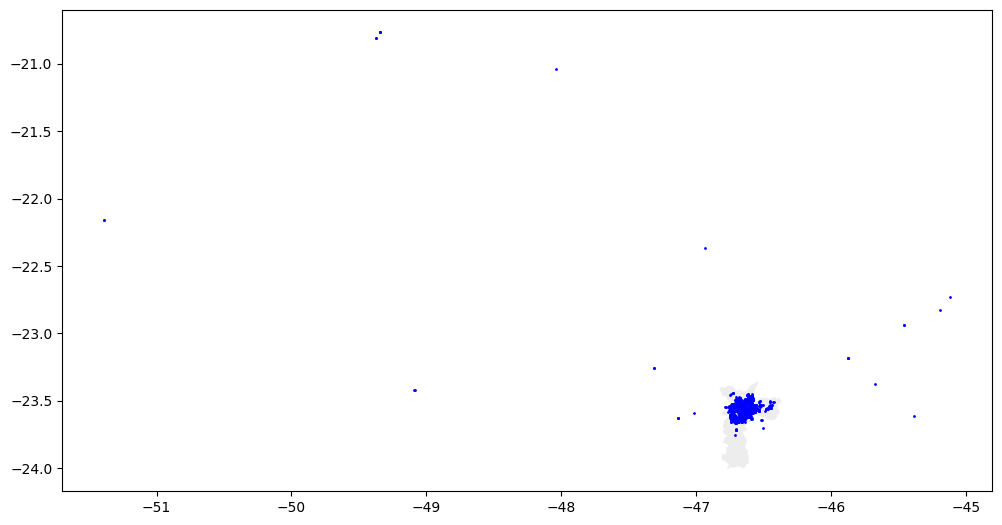

In [82]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (12, 12))

# plot mapa de São Paulo
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

gdf = gpd.GeoDataFrame(df_filtro, geometry=gpd.points_from_xy(df_filtro['coordinates'].apply(lambda x: x[1]), df_filtro['coordinates'].apply(lambda x: x[0])))
gdf.plot(ax=ax, markersize=1, color="blue")


NameError: name 'plt' is not defined

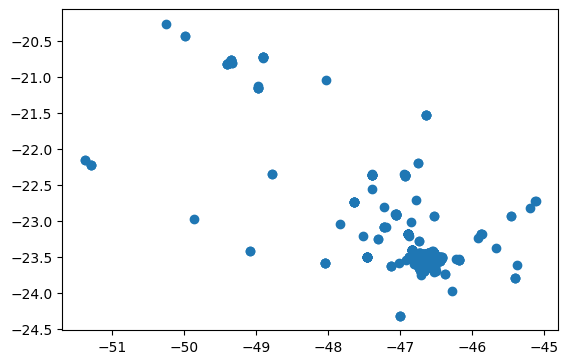

In [14]:
# Filtrar os registros com coordenadas válidas
df = df.dropna(subset=['coordinates'])

# Criar um GeoDataFrame a partir do DataFrame com as coordenadas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['coordinates'].apply(lambda x: x[1]), df['coordinates'].apply(lambda x: x[0])))

# Plotar os pontos no mapa
gdf.plot()

# Exibir o mapa
plt.show()